用意した車線ラベルをつないで計算した区間長と
qgis上で自分で測った区間長を比較する  
車線ラベルから区間長を計算しても、その誤差は小さい

In [6]:
import sys
from osgeo import gdal, ogr, osr
from pyproj import Transformer
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import numpy as np
from utils import isDrawvertline, calvertline

In [2]:
#車線の読み込みパス
RdCL_path = '../RodeOutline_HigasiOsaka/RdCL/RdLengthTest/no1/no1-in.csv'
#label
label_path = '../RodeOutline_HigasiOsaka/RdCL/RdLengthTest/no1/label_no1.csv'

In [3]:
#まとめ
result = {'no':[], 'in-out':[], 'diff':[], 'ratio':[]}

for no in ['no1', 'no2', 'no3', 'no4', 'no5', 'no6', 'no7', 'no8', 'no9', 'no10']:
    for direction in ['in', 'out']:
        print('{}'.format(no))
        label_path = '../RodeOutline_HigasiOsaka/RdCL/RdLengthTest/' + no + '/label_' + no + '-' + direction + '.csv'
        #道路長の正解ラベルを読み込む
        label_df = pd.read_csv(label_path)
        label_df['WKT'] = label_df['WKT'].map(lambda x: ogr.CreateGeometryFromWkt(x))
        line = label_df['WKT'][0]
        lengths = []
        pt1 = line.GetPoint(0)
        for count in range(1, line.GetPointCount()):
            pt2 = line.GetPoint(count)
            pair1 = [pt1[1], pt1[0]]
            pair2 = [pt2[1], pt2[0]]
            length = geodesic(pair1, pair2).m
            lengths.append(length)
            pt1 = pt2
        L_label = sum(lengths)
        print('label: {}'.format(L_label))

        print('\n{}'.format(direction))
        RdCL_path = '../RodeOutline_HigasiOsaka/RdCL/RdLengthTest/' + no + '/' + no + '-' + direction +'.csv'
        #中心線の起点、終点を設定
        RdCL_df = pd.read_csv(RdCL_path)
        RdCL_df.dropna(subset=['WKT'], inplace = True)
        RdCL_df = RdCL_df.reset_index(drop = True)
        RdCL_df['WKT'] = RdCL_df['WKT'].map(lambda x: ogr.CreateGeometryFromWkt(x))
        anchor = {'start_long': [], 'start_lat': [], 'end_long':[], 'end_lat':[]}
        for id in RdCL_df.index.to_numpy():

            line = RdCL_df['WKT'][id]
            st = line.GetPoint(0)
            end = line.GetPoint(line.GetPointCount() - 1)
            anchor['start_long'].append(st[0])
            anchor['start_lat'].append(st[1])
            anchor['end_long'].append(end[0])
            anchor['end_lat'].append(end[1])
        RdCL_df = RdCL_df.join(pd.DataFrame(anchor))
        #各車線の長さを計算
        RdLen = {'Length':[]}
        for id in RdCL_df.index.to_numpy():
            line = RdCL_df['WKT'][id]
            lengths = []
            pt1 = line.GetPoint(0)
            for count in range(1, line.GetPointCount()):
                pt2 = line.GetPoint(count)
                pair1 = [pt1[1], pt1[0]]
                pair2 = [pt2[1], pt2[0]]
                length = geodesic(pair1, pair2).m
                lengths.append(length)
                pt1 = pt2
            RdLen['Length'].append(sum(lengths))  
        RdLen_df = pd.DataFrame(RdLen)
        RdCL_df = RdCL_df.join(RdLen_df)

        #車線グループから並列した車線の長い方を選ぶ
        RdDeleted = [] #並列した小さい方のid
        idnum = len(RdCL_df.index.to_list())
        check = np.zeros((idnum, idnum)) #どれとどれが並列した車線かを管理するフラグ

        for id in RdCL_df.index.to_numpy():
            #print('crt id: {}'.format(id))
            if id in RdDeleted:
                continue
            line = RdCL_df['WKT'][id]
            for count in range(line.GetPointCount()):
                pt = line.GetPoint(count)
                pt = [pt[1], pt[0]]
                for id2 in RdCL_df.index.to_numpy():
                    if check[id][id2] == 1or id == id2 or id2 in RdDeleted:
                        continue
                    line2 = RdCL_df['WKT'][id2]
                    end1 = line2.GetPoint(0)
                    end1= [end1[1], end1[0]]
                    for count2 in range(1, line2.GetPointCount()):
                        end2 = line2.GetPoint(count2)
                        end2= [end2[1], end2[0]]
                        len1 = geodesic(pt, end1).m
                        len2 = geodesic(pt, end2).m
                        if len1 > len2:
                            #始点をend1に
                            temp = end1
                            end1 = end2
                            end2 = temp
                        if isDrawvertline(end1, end2, pt) >= 0:
                            vertL = calvertline(end1, end2, pt)
                            if vertL <= 10: #線上の点から道路に下ろす垂線が閾値以上ならば隣り合っていないと考える
                                l1 = RdCL_df['Length'][id]
                                l2 = RdCL_df['Length'][id2]
                                delid = id2 if  l1 >= l2 else id
                                RdDeleted.append(delid)
                                #print('    del id:{}'.format(delid))
                                check[id][id2] = 1
                                check[id2][id] = 1               
                                break
                        end1 = end2
                    if id in RdDeleted:
                        break
                if id in RdDeleted:
                        break
        #交差点などの車線がない部分をつないだ距離を計算
        addLen = []
        for id in RdCL_df.index.to_numpy():
            if id in RdDeleted:
                continue
            end = [RdCL_df['end_lat'][id], RdCL_df['end_long'][id]]
            st = [RdCL_df['start_lat'][id], RdCL_df['start_long'][id]]
            #endから一番近い始点との距離を追加
            lens = []
            for id2 in RdCL_df.index.to_numpy():
                if id == id2 or id2 in RdDeleted:
                    continue
                st2 = [RdCL_df['start_lat'][id2], RdCL_df['start_long'][id2]]
                l1 = geodesic(st, st2).m
                l2 = geodesic(end, st2).m
                if l1 > l2: #l１ < l2の時車線は繋がない
                    lens.append(l2)
                    #print('add len {} to {}'.format(id, id2))
            if lens:
                addLen.append(min(lens))

        #区間長さを計算
        #車線長さ　＋　交差点　ー　並列した車線長さ
#         print(addLen)
#         print(sum(addLen))
#         print(sum(RdCL_df['Length']) - sum(RdCL_df.loc[RdDeleted]['Length']))
        Lperiod = sum(RdCL_df['Length']) + sum(addLen) - sum(RdCL_df.loc[RdDeleted]['Length'])
        diff = Lperiod - L_label
        result['no'].append(no)
        result['in-out'].append(direction)
        result['diff'].append(diff)
        result['ratio'].append(abs(diff) / Lperiod)
    print(no + 'done')
print('done')

no1
label: 840.1455760163163

in
no1
label: 840.2366301551357

out
no1done
no2
label: 478.9747750521945

in
no2
label: 476.6216858117063

out
no2done
no3
label: 789.2787178137289

in
no3
label: 792.5214593955436

out
no3done
no4
label: 1271.8588181938985

in
no4
label: 1273.4439581445845

out
no4done
no5
label: 446.6451795824008

in
no5
label: 449.93684280572376

out
no5done
no6
label: 403.5585898371583

in
no6
label: 400.65312862540765

out
no6done
no7
label: 1382.4279830483465

in
no7
label: 1383.9922207671518

out
no7done
no8
label: 157.8067509781445

in
no8
label: 154.50181035156527

out
no8done
no9
label: 3537.9608373637825

in
no9
label: 3537.3304814008998

out
no9done
no10
label: 259.96939810265286

in
no10
label: 260.658097182445

out
no10done
done


In [4]:
result_df = pd.DataFrame(result)
result_df

,no,in-out,diff,ratio
0,no1,in,0.440449,0.000524
1,no1,out,4.876056,0.005770
2,no2,in,3.759389,0.007788
3,no2,out,2.553000,0.005328
4,no3,in,3.833983,0.004834
5,no3,out,5.062411,0.006347
6,no4,in,3.947621,0.003094
7,no4,out,3.262017,0.002555
8,no5,in,1.536194,0.003428
9,no5,out,3.686045,0.008126


In [22]:
result_df['ratio'].describe()

count    20.000000
mean      0.003745
std       0.003428
min       0.000200
25%       0.000873
50%       0.002825
75%       0.005438
max       0.013595
Name: ratio, dtype: float64

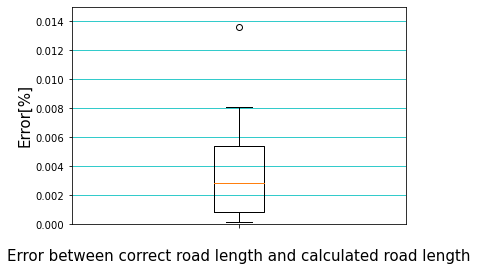

In [24]:
dt = np.array(result_df['ratio'])
math = dt
# 国語の点数
# 点数のタプル
points = (math)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Error between correct road length and calculated road length'], fontsize=15, y = -0.08)

#plt.title('Box plot')
#plt.xlabel('exams')
plt.ylabel('Error[%]', fontsize=15)
# Y軸のメモリのrange
plt.ylim([0,0.015])
ax.grid(color = 'c', axis='y')

# 描画
plt.show()